# Exploratory Data Analysis Notebook

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['font.family'] = 'times'

In [35]:
measurements = ['T2',        # [°R]       Total temperature at fan inlet
                'T24',       # [°R]       Total temperature at LPC outlet
                'T30',       # [°R]       Total temperature at HPC outlet
                'T50',       # [°R]       Total temperature at LPT outlet
                'P2',        # [psia]     Pressure at fan inlet
                'P15',       # [psia]     Total pressure in bypass-duct
                'P30',       # [psia]     Total pressure at HPC outlet
                'Nf',        # [rpm]      Physical fan speed
                'Nc',        # [rpm]      Physical core speed
                'epr',       # [-]        Engine pressure ratio (P50/P2)
                'Ps30',      # [psia]     Static pressure at HPC outlet
                'phi',       # [pps/psi]  Ratio of fuel flow to Ps30
                'NRf',       # [rpm]      Corrected fan speed
                'NRc',       # [rpm]      Corrected core speed
                'BPR',       # [-]        Bypass Ratio
                'farB',      # [-]        Burner fuel-air ratio
                'htBleed',   # [-]        Bleed Enthalpy
                'Nf_dmd',    # [rpm]      Demanded fan speed
                'PCNfR_dmd', # [rpm]      Demanded corrected fan speed
                'W31',       # [lbm/s]    HPT coolant bleed
                'W32']       # [lbm/s]    LPT coolant bleed 

settings = ['setting1', 'setting2', 'setting3']

In [36]:
# Read the .txt file
data = pd.read_csv('CMAPSSData/train_FD001.txt', header = None, sep = ' ')
# Rename the columns approprietly
data.columns = ['unitNumber', 'timeCycles'] + settings + measurements + ['drop1', 'drop2']
# Drop the two NaN columns
data = data.drop(columns = ['drop1', 'drop2'])
data.head()

,unitNumber,timeCycles,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


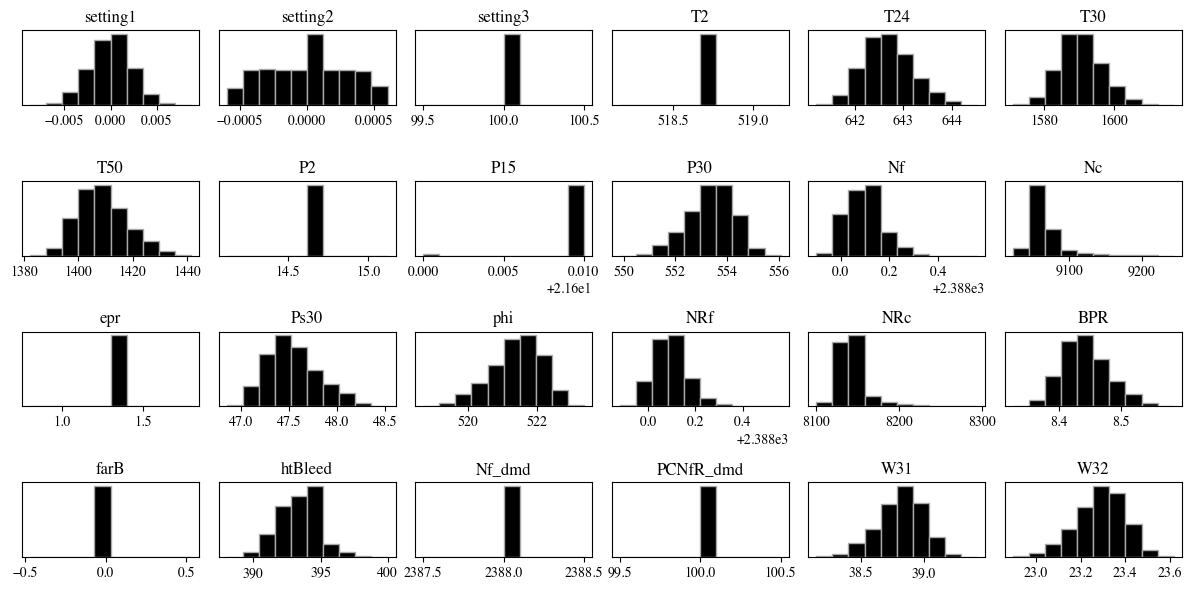

In [37]:
fig, ax = plt.subplots(4, 6, figsize = (12, 6)); ax = ax.flatten()
for i, feature in enumerate(settings + measurements) :

    ax[i].hist(data[feature], color = 'k', edgecolor = 'darkgrey')
    ax[i].set_title(feature)
    ax[i].set_yticks([])

plt.tight_layout(w_pad = 0.01)
plt.show()

In [38]:
# Print list of constant features
constantFeatures = ['P15'] # This feature is constant + some corrupted/outliers values
for feature in settings + measurements :
    if data[feature].min() == data[feature].max() :
        print(feature)
        constantFeatures.append(feature)

data = data.drop(columns = constantFeatures)
settings = [sett for sett in settings if sett not in constantFeatures]
measurements = [meas for meas in measurements if meas not in constantFeatures]

setting3
T2
P2
epr
farB
Nf_dmd
PCNfR_dmd


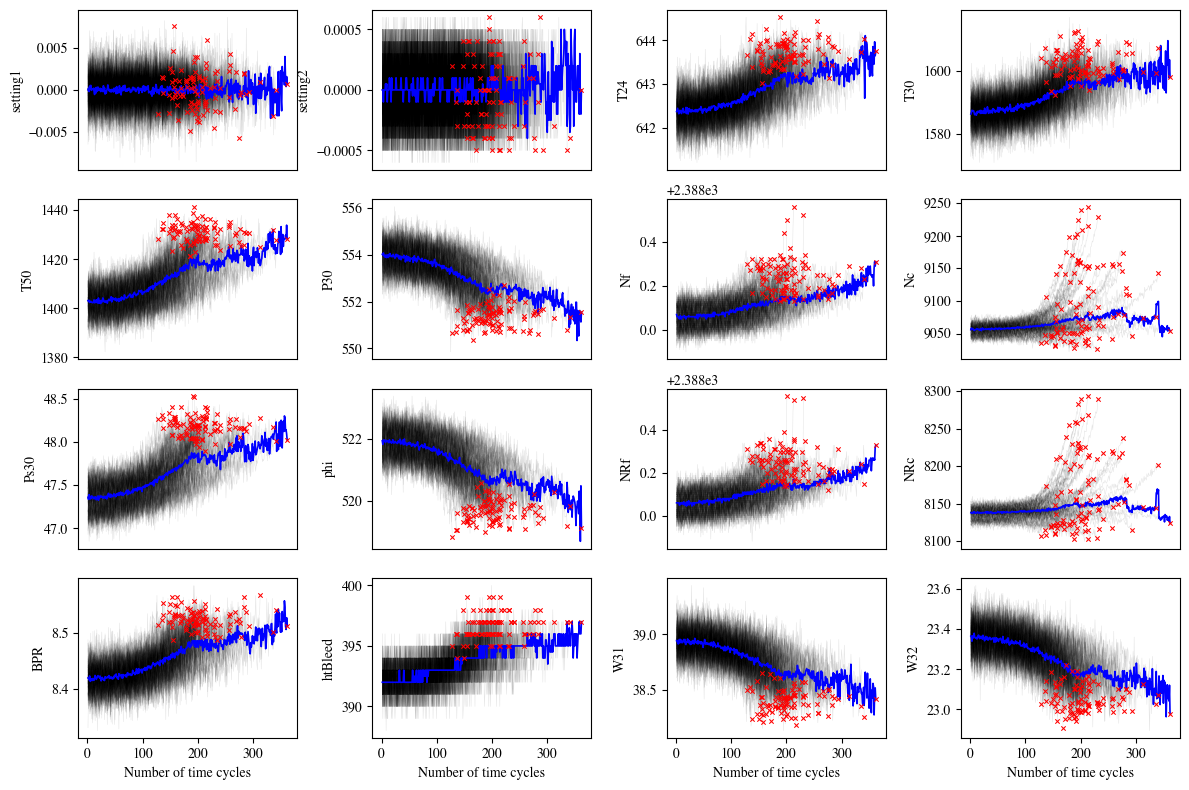

In [39]:
data_mean = data.groupby('timeCycles').median(settings + measurements).reset_index()

fig, ax = plt.subplots(4, 4, figsize = (12, 8)); ax = ax.flatten()

for i, feature in enumerate(settings + measurements) :
    ax[i].plot(data_mean['timeCycles'], data_mean[feature], c = 'blue', linewidth = 1.2, zorder = 0)
    for unit in list(data['unitNumber'].unique()) :
        dataUnit = data.groupby('unitNumber').get_group(unit)
        ax[i].plot(dataUnit['timeCycles'], dataUnit[feature], c = 'k', alpha = 0.1, linewidth = 0.4, zorder = -1)
        ax[i].scatter(dataUnit['timeCycles'].tail(1), dataUnit[feature].tail(1), c = 'red', marker = 'x', s = 10, zorder = 1, linewidth = 0.75)
    ax[i].set_ylabel(feature)   
    if i < 12 :
        ax[i].set_xticks([])
    else :
        ax[i].set_xlabel('Number of time cycles')     

plt.tight_layout(w_pad = 0.01)
plt.show()

In [40]:
RULs = data.groupby('unitNumber')['timeCycles'].max().reset_index().rename(columns = {'timeCycles': 'failTime'})
data = data.merge(RULs, on = 'unitNumber', how = 'left')
data['RUL'] = data['failTime'] - data['timeCycles']
data = data.drop(columns = ['failTime'])
data.head()

,unitNumber,timeCycles,setting1,setting2,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [41]:
# Export data
data.to_csv('Predictive Phase/processed_data.csv', index = None)

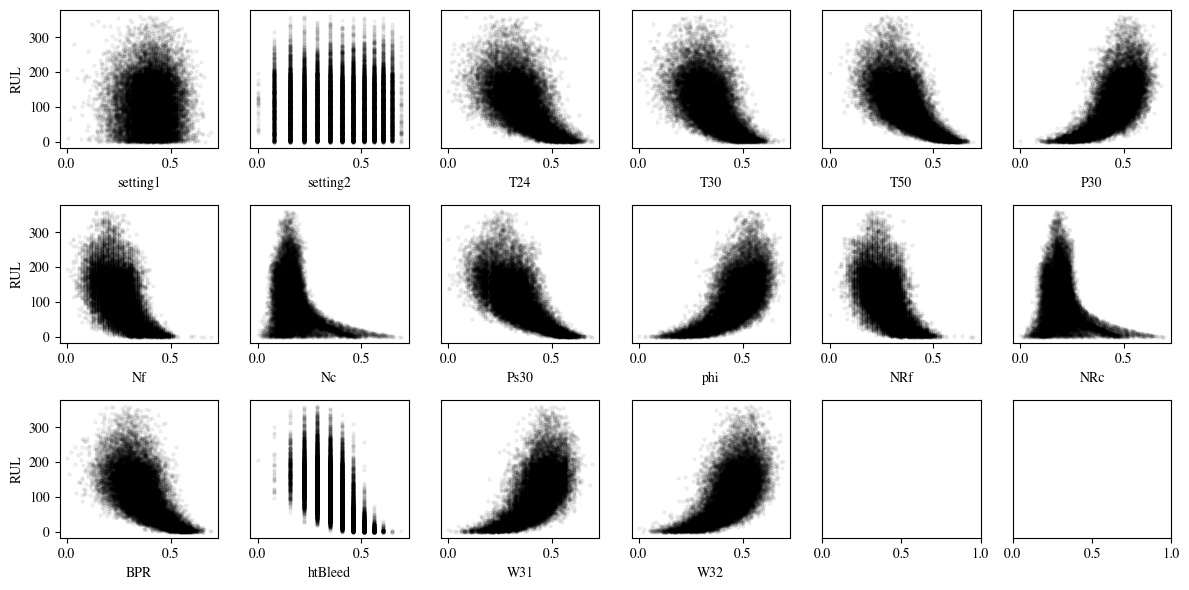

In [97]:
fig, ax = plt.subplots(3, 6, figsize = (12, 6)); ax = ax.flatten()

xs = np.linspace(0, 1, 1000)
for i, feature in enumerate(settings + measurements) :
    x, y = data[feature], data['RUL']
    x_norm = (x - x.min()) / (x.max() - x.min())
    ax[i].scatter(np.log(x_norm + 1), y, alpha = 0.05, c = 'k', s = 5)
    m, n = np.polyfit(x_norm, y, 1)
    a, b, c = np.polyfit(x_norm, y, 2)
  #  ax[i].plot(xs, m * xs + n)
   # ax[i].plot(xs, a * xs**2 + b * xs + c)
    ax[i].set_xlabel(feature)
    if i % 6 == 0:
        ax[i].set_ylabel('RUL')
    else :
        ax[i].set_yticks([])
ax[-2].set_yticks([]); ax[-1].set_yticks([])

plt.tight_layout()
plt.show()

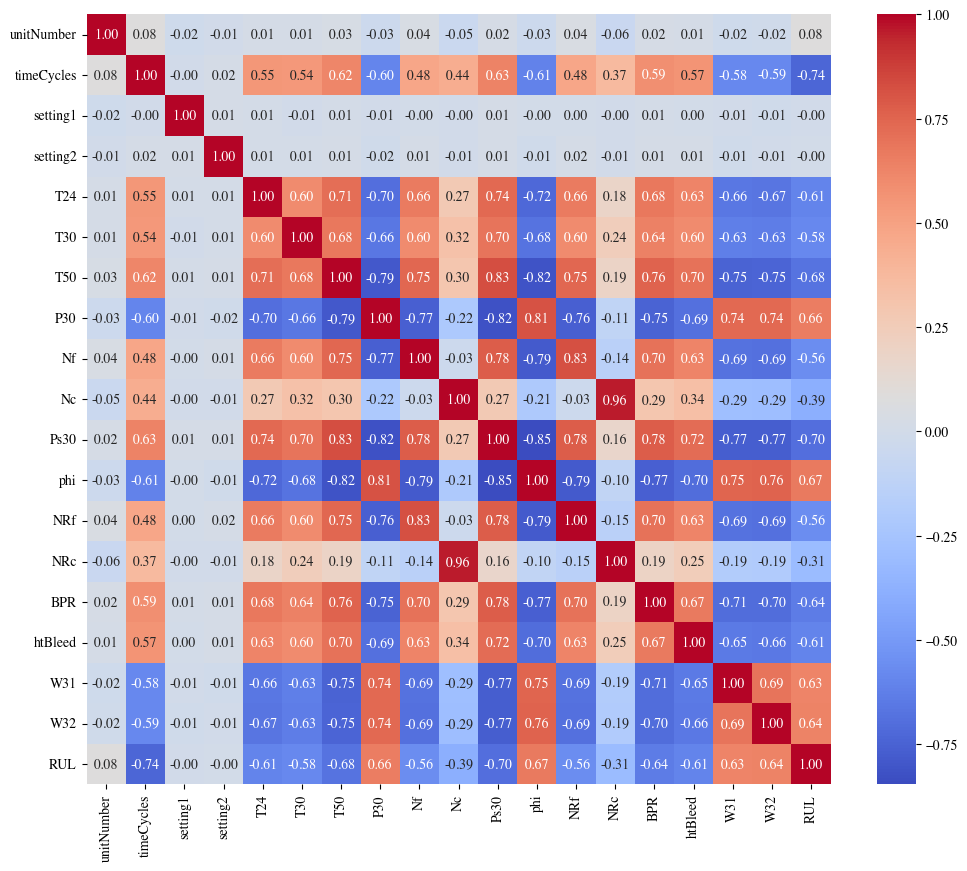

In [43]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

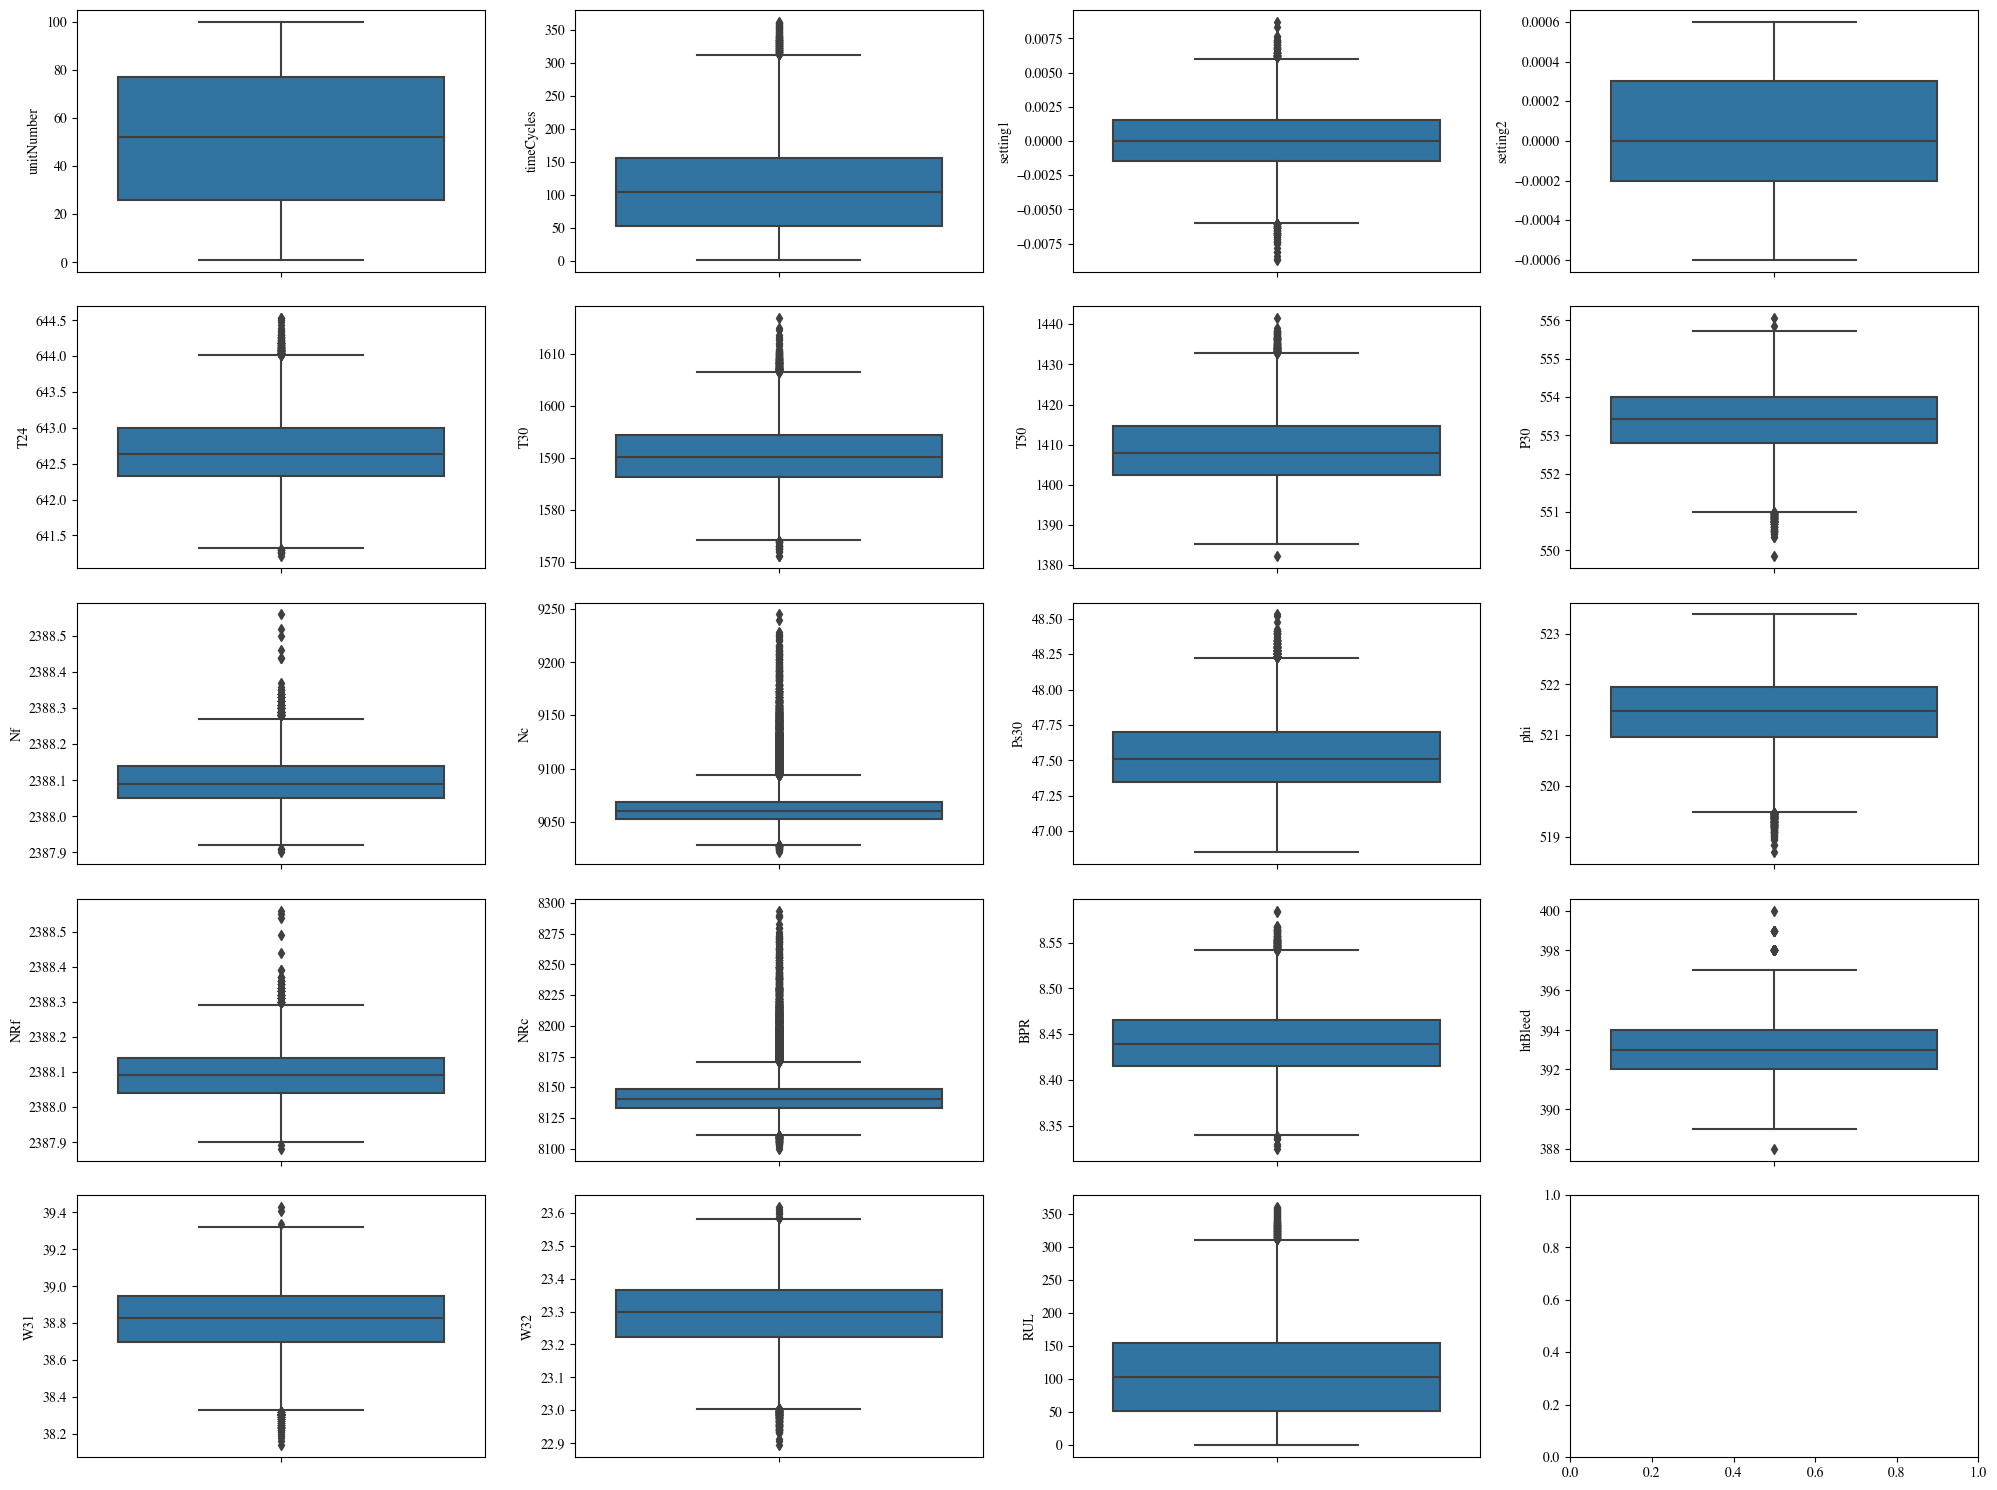

In [44]:
# Box plots for each feature
fig, ax = plt.subplots(5, 4, figsize=(20, 15)) # Adjust the size and layout as needed
ax = ax.flatten()
for i, col in enumerate(data.columns):
    sns.boxplot(y=col, data=data, ax=ax[i])
plt.tight_layout()
plt.show()


In [45]:
# Percentage of missing values for each feature
missing_percentage = data.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]
print(missing_percentage.sort_values(ascending=False))


Series([], dtype: float64)


In [76]:
xs = np.linspace(0, 1, 1000)
y = 0.1 * xs ** 2 + 0.5
yp = y + np.random.normal(0, .01, y.shape)

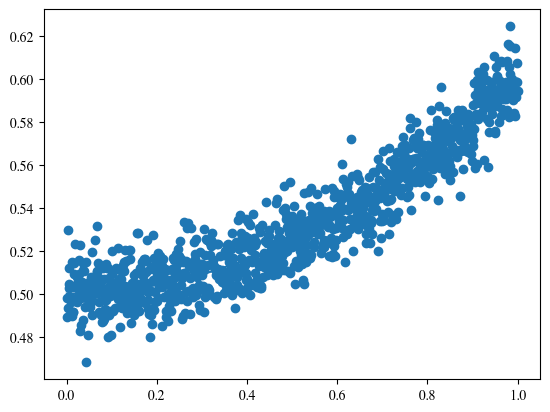

In [77]:
plt.plot(xs, y)
plt.scatter(xs, yp)

In [79]:
np.polyfit(xs, yp, 2)

array([ 0.10719304, -0.00919838,  0.50244509])